
a. a. Consider the dataset "exercise_21_01_26.npy" that contains $N = 20000$ observations $(\mathbf{x}_i \in \mathbb{R}^{10}, y_i \in \{-1, 1\})$, where $\mathbf{x}_i$ is a feature vector having 10 components and $y_i$ is the associated class label.

b. Implement a dimensionality reduction stage to reduce the number of features of the original data set to 2  Motivate whether the dimension ality reduction is suitable or not by observing the variance of the principal  components

c. Plot the data in the PCA domain and comment on the separability of the classification problem Choose a suitable decision statistic for this problem.  

d. Split the data into a training part (75% of the data) and a test part (the remaining observations).  

e Implement the optimal MAP classifier for the chosen decision statistic. To implement the MAP classifier,  postulate a suitable distribution for the data.  

f. Learn the parameters of the decision statistic by using the stochastic gradient descent algorithm.  

g. Compute the empirical error probability of the MAP classifier and the learned classifier.

In [6]:
import numpy as np

D = np.load("exercise_21_01_26.npy") #import dataset

X = D[:, :-1]     # features (20000,10) #raccogliamo tutte le features, prendi tutte le righe e tutte le colonne tranne l'ultima
Y = D[:, 10]      # label (20000,) #raccogliamo tutti i label, prendi tutte le righe e solo l'ultima colonna

print("=== DATASET INFO ===") 
print("Shape:", D.shape) #stampo le dimensioni del dataset

=== DATASET INFO ===
Shape: (20000, 11)


(20000, 2)


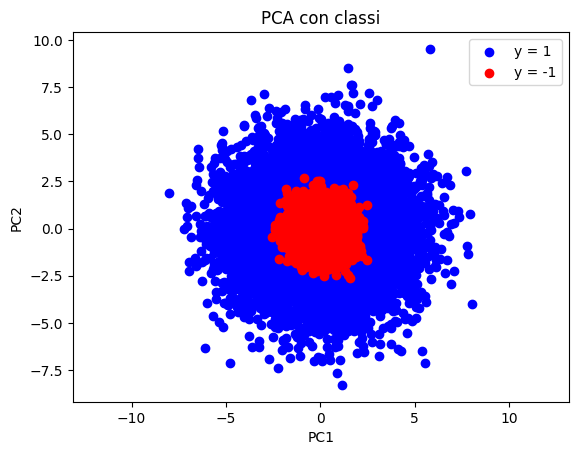

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2) #creo un oggetto PCA con 2 componenti principali
D_10 = D[:, :10] #prendo le prime 10 colonne del dataset
X_pca = pca.fit_transform(D_10) #applico la PCA alle prime 10 colonne del dataset, escludendo la 10-esima colonna (dove si trovano i label)

print(X_pca.shape)
plt.figure() #creo una figura

plt.scatter(
    X_pca[Y == 1, 0], #prendo nella prima componente principale i valori corrispondenti ai label(Y) = 1
    X_pca[Y == 1, 1], #prendo nella seconda componente principale i valori corrispondenti ai label(Y) = 1
    c="blue", #coloro di blu i valori corrispondenti ai label(Y) = 1
    label="y = 1", #labelo come y = 1
)
plt.scatter(
    X_pca[Y == -1, 0], #prendo nella prima componente principale i valori corrispondenti ai label(Y) = -1
    X_pca[Y == -1, 1], #prendo nella seconda componente principale i valori corrispondenti ai label(Y) = -1
    c="red", #coloro di rosso i valori corrispondenti ai label(Y) = -1
    label="y = -1", #labelo come y = -1
)

plt.axis("equal")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.title("PCA con classi")
plt.show()

la PCA cattura la struttura della varianza (la dispersione dei dati), ma non è necessariamente un algoritmo di classificazione.

Nel grafico si nota che le due classi ($y=1$ in blu e $y=-1$ in rosso) sono sovrapposte centralmente
La PCA ha fatto il suo lavoro proiettando i dati nelle direzioni di massima varianza. Notiamo che i dati blu hanno una varianza molto più elevata rispetto ai dati rossi

Poiché le due classi condividono lo stesso centro (media), la PCA non riesce a "separarle" in zone diverse del grafico. Dimostra che le classi sono distinguibili per la loro dispersione (varianza), ma non per la loro posizione media

Procedura per il calcolo della PCA (Punto A)Se abbiamo un dataset $X' \in \mathbb{R}^{n \times p}$ (dove $n$ è il numero di campioni e $p$ il numero di variabili), il vettore media $\mathbf{\mu}$ contiene la media aritmetica di ogni colonna:$$\mathbf{\mu} = \frac{1}{n} \sum_{i=1}^{n} \mathbf{x}'_i = \left( \frac{1}{n} \sum_{i=1}^{n} x'_{i1}, \dots, \frac{1}{n} \sum_{i=1}^{n} x'_{ip} \right)$$Nel codice, questo vettore viene sottratto da ogni riga del dataset originale per ottenere la matrice centrata $X$ (spesso chiamata X_centered nelle implementazioni):$$X = \begin{bmatrix} \mathbf{x}'_1 - \mathbf{\mu} \\ \mathbf{x}'_2 - \mathbf{\mu} \\ \vdots \\ \mathbf{x}'_n - \mathbf{\mu} \end{bmatrix}$$Ogni riga della matrice finale $X$ avrà quindi media nulla, il che è il requisito fondamentale per calcolare correttamente la matrice di covarianza $S$:$$S = \frac{1}{n-1} X^T X$$

In [8]:
D_10 = D[:, :10] #prendo le prime 10 colonne del dataset

D_10_mean= np.mean(D_10, axis=0) #calcolo la media delle prime 10 colonne del dataset
#axis=0: calcolo la media per ogni colonna, axis=1: calcolo la media per ogni riga

X_centered= D_10 - D_10_mean #centro i dati rispetto alla media

$$C = \frac{1}{n-1} X^T X$$
Dove:
$X$ è la matrice dei dati centrati (quella che nel codice chiami X_centered).
$X^T$ è la trasposta della matrice centrata.$n$ è il numero di osservazioni (righe del dataset, ovvero D_10.shape[0]).

Il prodotto $X^T X$ è il prodotto matriciale che somma i prodotti incrociati delle variabili.

In [9]:
C = (1 / (D_10.shape[0] - 1)) * X_centered.T @ X_centered #10X10

eigvals, eigvecs = np.linalg.eigh(C) #calcolo gli autovalori e gli autovettori della matrice C

Decomposizione Spettrale (Eigendecomposition)

La funzione np.linalg.eigh(C) risolve l'equazione caratteristica della matrice di covarianza:$$C \mathbf{v} = \lambda \mathbf{v}$$
Dove:

$\lambda$ (Autovalori / Eigvals): Rappresentano la quantità di varianza spiegata da ogni componente. Più alto è l'autovalore, più importante è quella direzione.

$\mathbf{v}$ (Autovettori / Eigvecs): Rappresentano le direzioni (i nuovi assi del sistema di coordinate) nello spazio originale. Questi vettori sono tra loro ortogonali (perpendicolari).

Nota tecnica: Si usa eigh invece di eig perché la matrice di covarianza è simmetrica. eigh è più veloce e numericamente più stabile per matrici simmetriche.

Per trovare questi valori di $\lambda$, dobbiamo risolvere l'equazione caratteristica:$$\det(C - \lambda I) = 0$$

In [10]:
idx = np.argsort(eigvals)[::-1] # Restituisce gli indici che ordinerebbero l'array in modo crescente
eigvals = eigvals[idx] #ordino gli autovalori in modo decrescente
eigvecs = eigvecs[:, idx] #ordino gli autovettori in modo decrescente

Cosa ottieni dopo l'ordinamento?

eigvals[0]: La varianza spiegata dalla Prima Componente Principale (PC1).

eigvecs[:, 0]: Il vettore che definisce la direzione della PC1.

In [11]:
W = eigvecs[:, :2] #prendo solo le prime 2 colonne degli autovettori

L'obiettivo è trovare una direzione $w$ (un vettore) tale che, quando proiettiamo i dati su di essa, la varianza sia massima.

$$w^{(1)} = \arg \max_{w \in \mathbb{R}^p} \left\{ \frac{1}{n-1} \sum_{i=1}^{n} \left( \sum_{j=1}^{p} x_{ij}w_j \right)^2 \right\} \quad \text{con vincolo } \|w\| = 1$$

Principal Component Score:

 Il termine $\sum_{j=1}^p x_{ij}w_j$ è il prodotto scalare tra il dato $x_i$ e il vettore direzione $w$. 
 
 Rappresenta la proiezione del punto sulla nuova retta.Massimizzazione: Elevando al quadrato e mediando ($\frac{1}{n-1}\sum$), stiamo cercando la direzione che mantiene la più alta dispersione (varianza) dei dati originali.
 (riga a seguire non si farà solo per la prima componente ma per tutte le componenti presenti in w)

In [12]:
X_pca_manual = X_centered @ W #proietto i dati centrati sulle prime 2 componenti principali tramite prodotto matriciale tra X senza media e W

letteralmente
$T= XW$

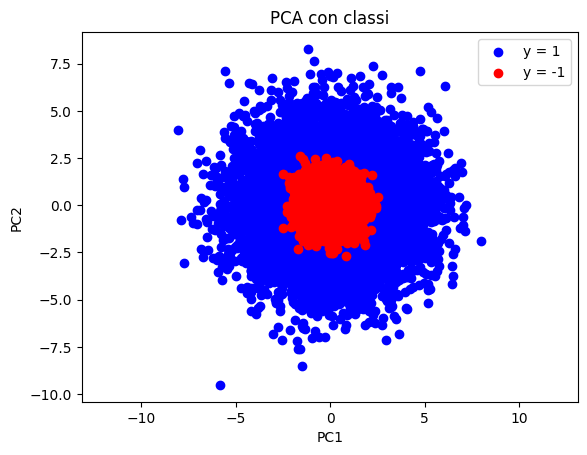

In [13]:

plt.figure()

plt.scatter(
    X_pca_manual[Y == 1, 0],
    X_pca_manual[Y == 1, 1],
    c="blue",
    label="y = 1",
)
plt.scatter(
    X_pca_manual[Y == -1, 0],
    X_pca_manual[Y == -1, 1],
    c="red",
    label="y = -1",
)
plt.axis("equal")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.title("PCA con classi")
plt.show()

**Punto B**

In [14]:
# Gli autovalori sono già le varianze di PC1, PC2, ..., PCn
varianze_assolute = eigvals 
for i, v in enumerate(varianze_assolute):
    print(f"Varianza spiegata dalla PC{i+1}: {v:.4f}")

varianza_totale=np.sum(eigvals)
varianza_spiegata_ratio = eigvals / varianza_totale #il totale di tutte varianza_spiegata_ratio sarà 1
print(np.sum(varianza_spiegata_ratio))


Varianza spiegata dalla PC1: 2.7710
Varianza spiegata dalla PC2: 2.7076
Varianza spiegata dalla PC3: 0.0026
Varianza spiegata dalla PC4: 0.0026
Varianza spiegata dalla PC5: 0.0026
Varianza spiegata dalla PC6: 0.0025
Varianza spiegata dalla PC7: 0.0025
Varianza spiegata dalla PC8: 0.0025
Varianza spiegata dalla PC9: 0.0025
Varianza spiegata dalla PC10: 0.0024
1.0


 Qui applichi la formula $\text{Ratio}_j = \frac{\lambda_j}{\sum \lambda}$.
 Stiamo normalizzando i dati rispetto alla varianza totale (5.49878450608)

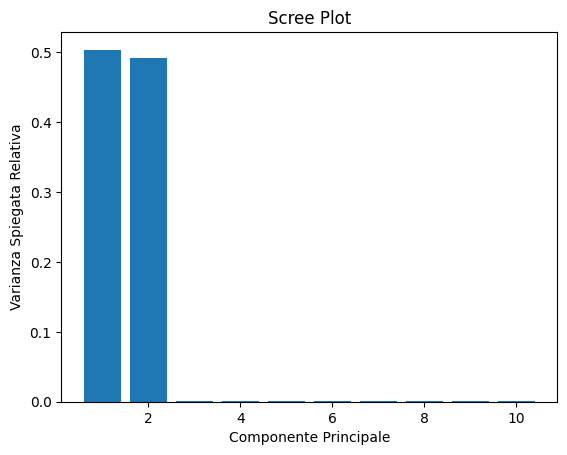

In [15]:

plt.bar(x=range(1, len(varianza_spiegata_ratio) + 1), height=varianza_spiegata_ratio) #il for in py esclude l'ultimo valore
#sull'asse x ci saranno da 1 a a 10 componenti
plt.ylabel('Varianza Spiegata Relativa')
plt.xlabel('Componente Principale')
plt.title('Scree Plot')
plt.show()

Analisi della Varianza: Dallo Scree Plot generato, si osserva che le prime due componenti (PC1 e PC2) hanno ciascuna una varianza spiegata relativa prossima a 0.5 (50%).

Sommando i ratio delle prime due componenti ($\approx 0.5 + \approx 0.5$), otteniamo quasi il 100% della varianza totale. Le restanti componenti (dalla 3 alla 10) hanno valori prossimi allo zero, la loro somma è 0.003222002196239549 su 1, indicando che non contengono informazione significativa ma solo rumore o ridondanza.

La riduzione dimensionale a $k=2$ è estremamente adeguata. Passare da 10 dimensioni a 2 permette di mantenere la quasi totalità dell'informazione originale, rendendo i dati facilmente visualizzabili senza perdite rilevanti.

**PUNTO C**

c. Plot the data in the PCA domain and comment on the separability of the classification problem Choose a suitable decision statistic for this problem.  

Come si osserva dallo scatter plot, le classi non sono linearmente separabili. Un classificatore lineare fallirebbe perché le medie delle due classi coincidono nell'origine dopo la centratura.
Il problema è altamente separabile, ma serve una frontiera di decisione circolare o non lineare.

Poiché la differenza tra le classi dipende dalla distanza dal centro, la statistica di decisione più naturale è la norma Euclidea (la distanza dei punti dall'origine).

Distanza Radiale (Semplice):$$T(x) = \|x_{PCA}\|^2 = PC1^2 + PC2^2$$

Si assegna alla classe rossa se la distanza dall'origine è minore di una soglia $\tau$, altrimenti alla classe blu.

Questa statistica permette di definire una soglia radiale $\tau$ tale che:

Se $T(x) < \tau \implies y = -1$ (Classe interna)

Se $T(x) > \tau \implies y = 1$ (Classe esterna)

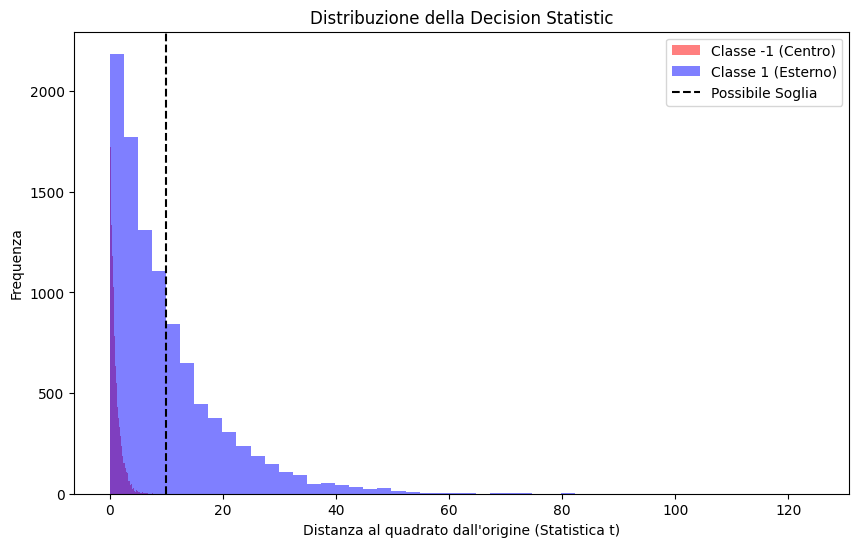

Distanza media classe -1 (Rossi): 1.0032
Distanza media classe 1 (Blu): 9.9134


In [ ]:
# Calcoliamo la statistica di decisione (distanza al quadrato dall'origine)
# X_pca_manual ha dimensioni (20000, 2)
distanze_quadrate = np.sum(X_pca_manual**2, axis=1)

# Visualizziamo come si distribuiscono le distanze per le due classi
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(distanze_quadrate[Y == -1], bins=50, alpha=0.5, label='Classe -1 (Centro)', color='red')
plt.hist(distanze_quadrate[Y == 1], bins=50, alpha=0.5, label='Classe 1 (Esterno)', color='blue')
plt.axvline(x=10, color='black', linestyle='--', label='Possibile Soglia') # Esempio di soglia
plt.xlabel('Distanza al quadrato dall\'origine (Statistica t)')
plt.ylabel('Frequenza')
plt.legend()
plt.title('Distribuzione della Decision Statistic')
plt.show()
# Verifichiamo la separabilità stampando le medie della statistica per le due classi
print(f"Distanza media classe -1 (Rossi): {decision_stat[Y == -1].mean():.4f}")
print(f"Distanza media classe 1 (Blu): {decision_stat[Y == 1].mean():.4f}")

Qui stai visualizzando la tua Decision Statistic $T(x) = PC1^2 + PC2^2$.

Classe -1 (Rossi - Nucleo): La distribuzione rossa è strettissima e schiacciata vicino allo zero (Distanza media $\approx 1$). Questo conferma che i punti rossi sono tutti raggruppati vicinissimi all'origine.

Classe 1 (Blu - Corona): La distribuzione blu è molto più larga e spalmata verso destra (Distanza media $\approx 9.9$). Anche se alcuni punti blu sono vicini al centro, la maggior parte ha un'energia molto più alta.

Se scegliessi una soglia $\tau \approx 3$, potresti dire: "Tutto ciò che è sotto 3 è Rosso, tutto ciò che è sopra è Blu". Sbaglieresti solo pochi punti blu che cadono dentro il cerchio rosso, ma avresti una precisione altissima.

**PUNTO D**

d. Split the datat into a training part (75% of the data) and a test part (the remaining observations).  

In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_pca_manual,     #Rappresenta la matrice dei dati 
    Y,     #La funzione deve dividere anche questo vettore nello stesso identico ordine di Dataset, in modo che ogni punto in D abbia ancora la sua etichetta corrispondente in y_train.
    test_size=0.25, 
    random_state=42,  #Assicura che la suddivisione sia riproducibile. Ogni volta che eseguirai il codice, otterrai gli stessi identici set di dati.
    stratify=Y       #Questo parametro assicura che la proporzione tra le classi (rossi e blu) rimanga la stessa sia nel training che nel test set.
)  

# Verifica delle dimensioni
print(f"Dimensioni Training set: {X_train.shape} campioni")
print(f"Dimensioni Test set: {X_test.shape} campioni")




Dimensioni Training set: (15000, 2) campioni
Dimensioni Test set: (5000, 2) campioni


**PUNTO E**

e. Implement the optimal MAP classifier for the chosen decision statistic. To implement the MAP classifier,  postulate a suitable distribution for the data.  

vedere il pdf per il ragionamento eseClassificatore.pdf

=== PERFORMANCE REPORT ===
Accuratezza del classificatore MAP: 0.8474


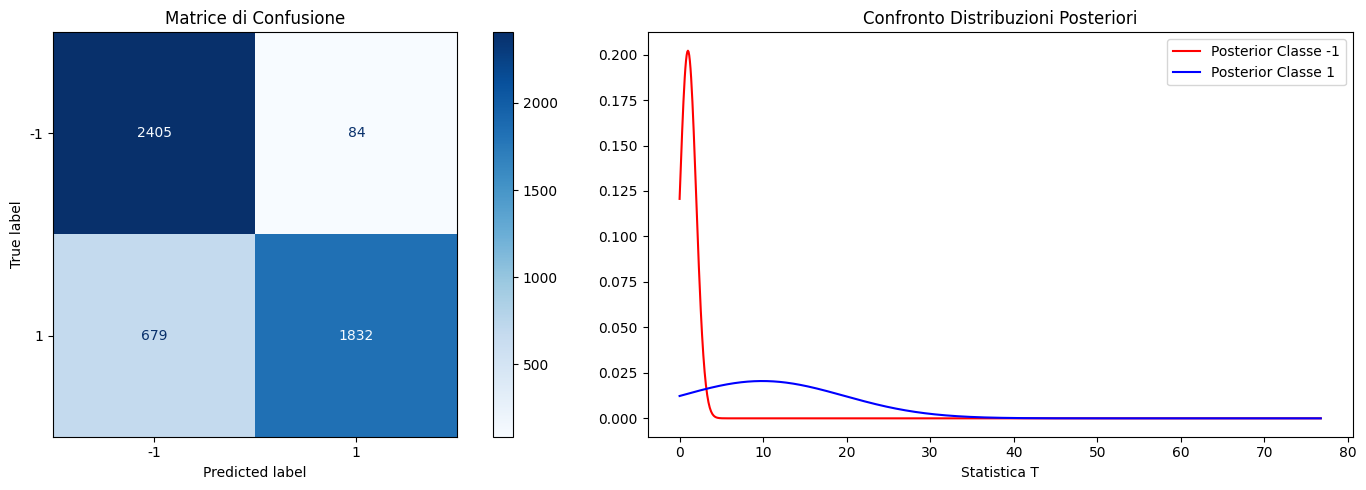

In [42]:
import numpy as np
from math import sqrt
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# 1. Calcolo della statistica di decisione T (distanza al quadrato dall'origine)
T_train = np.sum(X_train**2, axis=1)
T_test = np.sum(X_test**2, axis=1)

# 2. Parametri per la Classe -1 (Centro)
mu_neg = np.mean(T_train[y_train == -1])
var_neg = np.var(T_train[y_train == -1])
prior_neg = np.mean(y_train == -1)

# 3. Parametri per la Classe 1 (Esterno)
mu_pos = np.mean(T_train[y_train == 1])
var_pos = np.var(T_train[y_train == 1])
prior_pos = np.mean(y_train == 1)

# 4. Implementazione Regola MAP sul Test Set
# Calcoliamo f(T|y)*P(y) per entrambe le classi
posterior_neg = norm.pdf(T_test, mu_neg, sqrt(var_neg)) 
posterior_pos = norm.pdf(T_test, mu_pos, sqrt(var_pos)) 

# Se il punteggio della classe 1 è maggiore, prediciamo 1, altrimenti -1
y_pred = np.where(posterior_pos > posterior_neg, 1, -1)

# --- VERIFICA DELLE PRESTAZIONI ---

# Calcolo accuratezza
accuracy = accuracy_score(y_test, y_pred)
print(f"=== PERFORMANCE REPORT ===")
print(f"Accuratezza del classificatore MAP: {accuracy:.4f}")

# Matrice di Confusione
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Matrice di Confusione
disp.plot(ax=ax[0], cmap='Blues')
ax[0].set_title("Matrice di Confusione")

# Plot 2: Distribuzione e soglia decisionale
x_range = np.linspace(0, np.max(T_test), 1000)
ax[1].plot(x_range, norm.pdf(x_range, mu_neg, sqrt(var_neg)) * prior_neg, color='red', label='Posterior Classe -1')
ax[1].plot(x_range, norm.pdf(x_range, mu_pos, sqrt(var_pos)) * prior_pos, color='blue', label='Posterior Classe 1')
ax[1].set_title("Confronto Distribuzioni Posteriori")
ax[1].set_xlabel("Statistica T")
ax[1].legend()

plt.tight_layout()
plt.show()

**PUNTO F**


f. Learn the parameters of the decision statistic by using the stochastic gradient descent algorithm.  

imparare dai dati significa risolvere questo problema:

$$\min_{\beta} J(\beta)$$

dove beta sono i parametri del modello, $J(\beta)$: È la funzione di costo. Rappresenta quanto il modello sta andando male.


La Funzione Loss ($Q_\beta(d)$): È il "metro" che misura quanto è sbagliata una singola previsione su un singolo dato.

$$Q_\beta(x, y) = \ln(1 + e^{-y x^\top \beta})$$

Il Rischio o Costo ($J(\beta)$): Siccome non ci interessa essere precisi su un solo dato ma su tutti i dati possibili, calcoliamo il valore atteso (la media teorica) della Loss:

Rischio Vero (Atteso)Questo rappresenta l'errore medio calcolato sulla distribuzione teorica di tutti i possibili dati. Qui $X$ e $Y$ sono variabili aleatorie.$$J(\beta) = \mathbb{E}[\ln(1 + e^{-Y X^\top \beta})]$$

Rischio Empirico (Sui dati)

$$J(\beta) = \frac{1}{m} \sum_{i=1}^{m} \ln(1 + e^{-y_i (\mathbf{x}_i^\top \beta)})$$



L'obiettivo dell'algoritmo sarà trovare i parametri $\beta$ che rendono minima questa espressione logaritmica.

La previsione è fatta con un prodotto scalare $X^\top \beta$. 

Il Margine: La quantità $z = y \cdot (\mathbf{x}^T \beta)$ è chiamata margine. Se il margine è positivo, il modello sta predicendo la classe corretta.



In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# 1. Preparazione dei dati (Assicuriamoci che y sia una colonna)
m = X_train.shape[0] # mi prendo il numero di osservaizoni
y_train_col = y_train.reshape(-1, 1) # Fondamentale per il prodotto matriciale, passa da 1D a 2D

# Prendiamo le 10 feature originali e le eleviamo al quadrato
# (Come suggerito dalla nostra analisi radiale/PCA)
X_train_squared = (X_train[:, :10])**2

# Scaling: Lo SGD è sensibilissimo alla scala dei dati
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_squared)  
#in questo modo tutti i dati hanno media 0 e varianza 1

# Aggiunta del bias (intercetta beta_0)
X_b = np.c_[np.ones((m, 1)), X_train_scaled]
#ad ogni osservazione accanto si associa il valore dell'intercetta 1


Invece di usare un solo punto (Stochastic) o tutto il dataset (Batch) per ogni aggiornamento, usiamo un gruppo di 256 campioni per calcolare il gradiente.
Un'epoca rappresenta un passaggio completo attraverso l'intero set di dati di addestramento. nel mio caso , il numeor delle epoche è 100, l'algoritmo vedrà ogni singolo dato 100 volte prima di fermarsi.
Perché ad ogni epoca i pesi $\beta$ vengono corretti solo di poco; servono molti passaggi affinché il modello "aggiusti il tiro" e converga verso il minimo dell'errore.

Lo Shuffling: All'inizio di ogni epoca, rimescoli i dati con np.random.permutation. Questo serve a garantire che il modello non impari l'ordine dei dati, ma la loro struttura intrinseca, migliorando la generalizzazione.

formula "pulita" del gradiente per un singolo punto:

$$\nabla J_i(\beta) = \frac{-y_i \mathbf{x}_i}{1 + e^{y_i (\mathbf{x}_i^T \beta)}}$$

ossia la derivata delle funzione\ J(B)

C:\Users\frank\AppData\Local\Temp\ipykernel_17144\299969657.py:37: RuntimeWarning: overflow encountered in exp
  denominators = 1 + np.exp(margins)


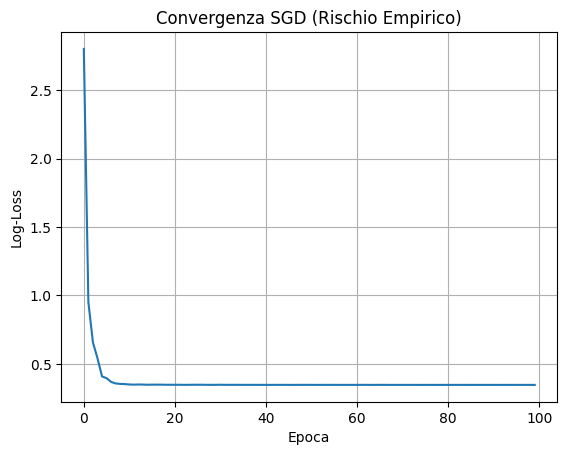

--- RISULTATI ---
Accuratezza SGD Manuale: 85.04%
Miglior Loss:           0.346239


In [78]:

# 2. Inizializzazione Parametri
n_epochs = 100
batch_size = 250
tau = 100
beta = np.zeros((X_b.shape[1], 1)) 

best_loss = float('inf')
best_beta = beta.copy()
history_loss = []

# Funzione per il decadimento del learning rate
def learning_schedule(epoch):
    return tau / (epoch+1) # Decadimento più lento per stabilità

# 3. Loop Mini-batch SGD
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y_train_col[shuffled_indices]
    
    mu = learning_schedule(epoch)
    epoch_losses = []
    
    for i in range(0, m, batch_size):
        xi = X_b_shuffled[i : i + batch_size]
        yi = y_shuffled[i : i + batch_size] 
        
        # Calcolo Margine: y * (beta_0 + beta_1*x1^2 + ...)
        margins = yi * (xi @ beta)
        
        # Calcolo Loss (Log-Loss): ln(1 + exp(-margine))
        loss_batch = np.mean(np.log(1 + np.exp(-margins)))
        epoch_losses.append(loss_batch)
        
        # Calcolo Gradiente per Logistic Loss
        # Grad = -y / (1 + exp(y * x @ beta)) * x
        denominators = 1 + np.exp(margins)
        gradients = (xi.T @ (-yi / denominators)) / len(yi)
        
        # Aggiornamento
        beta = beta - mu * gradients
    
    current_loss = np.mean(epoch_losses)
    history_loss.append(current_loss)
    
    if current_loss < best_loss:
        best_loss = current_loss
        best_beta = beta.copy()

# 4. Visualizzazione
plt.plot(history_loss)
plt.title('Convergenza SGD (Rischio Empirico)')
plt.xlabel('Epoca'), plt.ylabel('Log-Loss')
plt.grid(True)
plt.show()

# 5. Valutazione e Confronto
y_pred_train = np.sign(X_b @ best_beta).flatten()
acc_sgd = np.mean(y_pred_train == y_train)

print(f"--- RISULTATI ---")
print(f"Accuratezza SGD Manuale: {acc_sgd*100:.2f}%")
print(f"Miglior Loss:           {best_loss:.6f}")
        


Autovalore minimo $\ge 0$: Conferma che in quel punto la funzione è convessa. 

Se la Hessiana è sempre $\succeq 0$, hai la certezza matematica che il tuo SGD non rimarrà mai bloccato in un minimo locale "finto". Qualsiasi punto in cui il gradiente è zero è il minimo globale dell'errore.

In [76]:
import numpy as np

# 1. Calcoliamo le probabilità p_i per ogni osservazione
# z = X * beta
z = X_b @ best_beta
# Sigmoide per ottenere le probabilità p (per la classe 1)
p = 1 / (1 + np.exp(-z))

# 2. Creiamo la componente diagonale p * (1 - p)
# Questi sono i "pesi" che indicano la curvatura della loss
W = p * (1 - p)

# 3. Calcoliamo la Hessiana: (1/m) * X.T * diag(W) * X
# Usiamo il broadcasting per efficienza invece di np.diag()
H = (X_b.T * W.T) @ X_b / m

# 4. Calcoliamo gli autovalori della Hessiana
autovalori = np.linalg.eigvals(H)

# 5. Verifica della condizione
is_psd = np.all(autovalori >= -1e-12) # Tolleranza numerica per lo zero

print(f"=== VERIFICA CONVESSITÀ ===")
print(f"Autovalore minimo: {np.min(autovalori):.12f}")
print(f"Autovalore massimo: {np.max(autovalori):.4f}")
print(f"La Hessiana è Semidefinita Positiva? {is_psd}")

=== VERIFICA CONVESSITÀ ===
Autovalore minimo: 0.002679449592
Autovalore massimo: 0.0901
La Hessiana è Semidefinita Positiva? True


**PUNTO F**

Calcolo dell'Errore Empirico ($P_e$)L'errore empirico è la frazione di previsioni sbagliate sul totale dei campioni di test:$$P_e = \frac{1}{n_{test}} \sum_{i=1}^{n_{test}} \mathbb{I}(y_i \neq \hat{y}_i)$$

Se l'etichetta è diversa (ERRORE) $\to$ 1Se l'etichetta è uguale (CORRETTO) $\to$ 0


In [83]:

# --- 1. ERRORE MAP CLASSIFIER ---
# Calcoliamo la statistica T sul test set
T_test = np.sum(X_test**2, axis=1)

std_neg=sqrt(var_neg)
std_pos=sqrt(var_pos)

# Calcolo delle probabilità a posteriori (solo Likelihood)
post_neg = norm.pdf(T_test, mu_neg, std_neg) 
post_pos = norm.pdf(T_test, mu_pos, std_pos) 

# Predizione MAP
y_pred_map = np.where(post_pos > post_neg, 1, -1)
error_map = np.mean(y_pred_map != y_test)

# --- 2. ERRORE LEARNED CLASSIFIER (SGD) ---
# Dobbiamo preparare il Test Set allo stesso modo del Training Set
# Usiamo lo scaler già addestrato sul training per evitare data leakage
X_test_squared = (X_test[:, :10])**2
X_test_scaled = scaler.transform(X_test_squared) 
X_test_b = np.c_[np.ones((X_test.shape[0], 1)), X_test_scaled]

# Predizione SGD (usando il miglior beta trovato)
y_pred_sgd = np.sign(X_test_b @ best_beta).flatten()
error_sgd = np.mean(y_pred_sgd != y_test)

# --- RISULTATI FINALI ---
print(f"=== EMPIRICAL ERROR PROBABILITY (TEST SET) ===")
print(f"MAP Classifier Error: {error_map:.4f} (Acc: {(1-error_map)*100:.2f}%)")
print(f"SGD Learned Error:   {error_sgd:.4f} (Acc: {(1-error_sgd)*100:.2f}%)")

=== EMPIRICAL ERROR PROBABILITY (TEST SET) ===
MAP Classifier Error: 0.1526 (Acc: 84.74%)
SGD Learned Error:   0.1540 (Acc: 84.60%)
